In [1]:
from math import pi
import numpy as np
import gzip
from scipy.stats import multivariate_normal
import time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Problem 1: 
# find $\sigma$ such that $E(\|x\|)=d$, where $x\sim \mathcal{N}(\vec 0, \sigma^2 I_n)$

The theoretical solution is given by the expression:

$$ E(\|x\|) = \sigma \sqrt{2} \frac{\Gamma((n+1)/2)}{\Gamma(n/2)}$$

See for example: see https://stats.stackexchange.com/questions/144893/what-is-the-expected-norm-mathbb-e-lvert-x-rvert-for-a-multivariate-normal

Therefore, for $E(\|x\|)=d$ and $n=3$ we have the following calculation of $\sigma$:

$$\sigma = \frac{\Gamma(3/2)}{\sqrt{2}}d = \frac{\sqrt{\pi}}{2\sqrt{2}}d$$

In [2]:
def get_sigma_square(d):
    return d ** 2 * pi / 8

def get_spherical_gaussian(d):
    mu = [0., 0., 0.]
    sigma_square = get_sigma_square(d)
    cov = [[sigma_square, 0., 0.], [0., sigma_square, 0.], [0., 0., sigma_square]]
    return multivariate_normal(mu, cov)

In [4]:
# Sanity check

pae = 5  # input distance
k = 100000  # number of randomizations
eps = 1e-2  # tolerance

dist = get_spherical_gaussian(pae)
distances = [np.sqrt(np.dot(x,x)) for x in dist.rvs(size=k)]
assert(abs(np.mean(distances) - pae) < eps)

# Problem 2:
# compute the probability mass of $\mathcal{N}(\vec 0, \sigma^2 I_n)$ restricted to the sphere 
# $$S=\{y\in\mathbb{R}^3\;|\; \|y-c\|^2 < r^2\}$$

In [5]:
pae = 7  # input PAE
c = 4  # distance between residues
r = 10  # contact threshold in Angstroms 
k = 100000  # number of randomizations

center = np.array([c, 0., 0.])
dist = get_spherical_gaussian(pae)

contact_prob = np.mean([int(np.dot(y-center, y-center) < r**2) for y in dist.rvs(size=k)])
contact_prob

0.7452

# Wrap up:

# How to compute the contact probability with these scripts?

Given residues C and R, with C being the center of the contact volume:

1) d = PAE(R, C) -- the one that evaluates the expected error on R if we align at C, provided by AlphaFold

2) r = contact volume radius about C -- typically 10Å in our setting

3) c = estimate of the distance between R and C -- provided by AlphaFold

The contact probability, according to the spherical Gaussian model, can be computed with the following function:

In [6]:
def contact_probability(d, r, c, k=10000):

    center = np.array([c, 0., 0.])
    dist = get_spherical_gaussian(d)
    return np.mean([int(np.dot(y-center, y-center) < r**2) for y in dist.rvs(size=k)])

In [7]:
d = 10
r = 10
c = 8

contact_probability(d, r, c)

0.3358

# Test

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio.PDB.PDBParser import PDBParser
from scipy.stats import pearsonr
import sys

sys.path.append('../../')
from global_variables import WORKSPACE

In [4]:
# Functions to compute the probability of contact

def cap(r, h):
    """
    Volume of the polar cap of the sphere with radius r and cap height h
    """
    return pi * (3 * r - h) * h ** 2 / 3


def vol(r):
    """
    Volume of sphere with radius r
    """
    return 4 * pi * r ** 3 / 3


def s2_minus_s1(r1, r2, d):

    """
    Volume of S2 outside of S1
    r1: radius of S1
    r2: radius of S2
    d: distance between center of S1 and center of S2
    """

    # S1 and S2 not in contact
    if d > r1 + r2:
        return vol(r2)

    # S1 sits inside S2
    elif (r2 > d + r1):
        return vol(r2) - vol(r1)

    # S2 sits inside S1
    elif (r1 > d + r2):
        return 0.

    # Center of S2 is outside S1
    elif d > r1:
        h1 = (r2 ** 2 - (d - r1) ** 2) / (2 * d)
        h2 = r1 - h1 + r2 - d
        return vol(r2) - cap(r1, h1) - cap(r2, h2)

    # Center of S2 is inside S1
    elif d <= r1:
        h1 = (r2 ** 2 - (r1 - d) ** 2) / (2 * d)
        h2 = d - r1 + h1 + r2
        return cap(r2, h2) - cap(r1, h1)

In [5]:
# Other functions

def get_structure(file):
    """
    Use Bio.PDB to parse protein structure.
    """

    id = file.split("AF-")[1].split("-model_v1")[0]

    if file.endswith('.gz'):
        with gzip.open(file, 'rt') as handle:
            return PDBParser().get_structure(id=id, file=handle)[0]
    else:
        with open(file, 'r') as handle:
            return PDBParser().get_structure(id=id, file=handle)[0]


def get_dist_matrix(chain) :
    """
    Compute the distance matrix between C-alpha of a protein.
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(chain) :
        for j, res2 in enumerate(chain) :
            m[i, j] = abs(res1["CA"] - res2["CA"])

    return m


def get_contact_map(chain, distance=10):
    """
    Compute the contact map between C-alpha of a protein.
    """

    dist_matrix = get_dist_matrix(chain)

    return dist_matrix < distance


def get_prob_contact(pae_value, dmap_value, distance=10):
    """
    Get probability of contact considering the distance
    between residues in the predicted structure and the
    Predicted Aligned Error (PAE).
    """

    if pae_value == 0:

        if dmap_value < distance:
            return 1
        else:
            return 0

    else:
        # Get the volume of res2 outside of res1
        vol_s2_out_s1 = s2_minus_s1(r1=distance, r2=pae_value, d=dmap_value)

        # Get the probability that s2 is out of s1
        p_s2_in_s1 = vol_s2_out_s1 / vol(pae_value)

        return 1 - p_s2_in_s1


def get_prob_cmap(chain, pae, distance=10) :
    """
    Compute the probabilities that each pair of residue in a protein are
    in contact taking into account the Predicted Aligned Error (PAE) and
    the PDB structure predicted by AlphaFold 2
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(chain):
        for j, res2 in enumerate(chain):
            d = abs(res1["CA"] - res2["CA"])
            m[i, j] = get_prob_contact(pae[i, j], d, distance)

    return m

In [6]:
# New method and comparison

def get_prob_cmap_alt(chain, pae, distance=10) :
    """
    Compute the probabilities that each pair of residue in a protein are
    in contact taking into account the Predicted Aligned Error (PAE) and
    the PDB structure predicted by AlphaFold 2
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(tqdm(chain, desc="Residue i")):
        for j, res2 in enumerate(chain):
            d = abs(res1["CA"] - res2["CA"])
            m[i, j] = 1 if i == j else contact_probability(pae[i, j], distance, d)

    return m


def compare_pcmaps(gene, seq_df, dataset_dir):
    """
    Compute cmaps in two alternative approaches and Person 
    correlation between the resulting matrices.
    """
    
    uni_id = seq_df[seq_df["Gene"] == gene].Uniprot_ID.values[0]
    pdb_path = f"{pdb_dir}/AF-{uni_id}-F1-model_v4.pdb"
    pae_path = f"{pae_dir}/{uni_id}-F1-predicted_aligned_error.npy"
    
    pdb = get_structure(pdb_path)["A"]
    pae = np.load(pae_path)
    
    t0 = time.perf_counter()
    pcmap = get_prob_cmap(pdb, pae)
    t1 = time.perf_counter()
    elapsed_min_original = (t1 - t0) / 60.0
    
    t2 = time.perf_counter()
    pcmap_alt = get_prob_cmap_alt(pdb, pae)
    t3 = time.perf_counter()
    elapsed_min_alt = (t3 - t2) / 60.0

    corr, pval = pearsonr(pcmap.flatten(), pcmap_alt.flatten())
    
    return pcmap, pcmap_alt, corr, pval, elapsed_min_original, elapsed_min_alt

In [10]:
def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


cgc_df = pd.read_csv(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [7]:
dataset_dir = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
pdb_dir = f"{dataset_dir}/pdb_structures"
cmaps_dir = f"{dataset_dir}/prob_cmaps"
pae_dir = f"{dataset_dir}/pae"

seq_df = pd.read_table(f"{dataset_dir}/seq_for_mut_prob.tsv")

In [11]:
df = seq_df[seq_df.Gene.isin(cgc_df.Gene)]
df_sorted = df.sort_values(by='Seq', key=lambda x: x.str.len(), ascending=True)
df_sorted[:10]

,Gene,Ens_Gene_ID,Ens_Transcr_ID,Uniprot_ID,F,Seq,Chr,Reverse_strand,Exons_coord,Seq_dna,Tri_context,Reference_info
2169,TMSB4X,ENSG00000205542,ENST00000451311,A2VCK8,1,MSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES,NC_000023.11,0.0,NaN,ATGTCTGACAAACCCGATATGGCTGAGATCGAGAAATTCGATAAGT...,"CAT,ATG,TGT,GTC,TCT,CTG,TGA,GAC,ACA,CAA,AAA,AA...",0
15715,COX6C,ENSG00000164919,ENST00000520468,A0A024R9B7,1,MAPEVLPKPRMRGLLARRLRNHMAVAFVLSLGVAALYKFRVADQRK...,NC_000008.11,1.0,NaN,ATGGCTCCCGAAGTTTTGCCAAAACCTCGGATGCGTGGCCTTCTGG...,"CAT,ATG,TGG,GGC,GCT,CTC,TCC,CCC,CCG,CGA,GAA,AA...",0
16236,CHCHD7,ENSG00000170791,ENST00000355315,Q9BUK0,1,MPSVTQRLRDPDINPCLSESDASTRCLDENNYDRERCSTYFLRYKN...,NC_000008.11,0.0,NaN,ATGCCCTCGGTAACACAGAGGCTGAGAGATCCTGACATAAATCCTT...,"CAT,ATG,TGC,GCC,CCC,CCT,CTC,TCG,CGG,GGT,GTA,TA...",0
9583,MLLT11,ENSG00000213190,ENST00000368921,Q13015,1,MRDPVSSQYSSFLFWRMPIPELDLSELEGLGLSDTATYKVKDSSVG...,NC_000001.11,0.0,NaN,ATGAGGGACCCTGTGAGTAGCCAGTACAGTTCCTTTCTTTTCTGGA...,"CAT,ATG,TGA,GAG,AGG,GGG,GGA,GAC,ACC,CCC,CCT,CT...",0
4997,S100A7,ENSG00000143556,ENST00000368723,P31151,1,MSNTQAERSIIGMIDMFHKYTRRDDKIEKPSLLTMMKENFPNFLSA...,NC_000001.11,1.0,NaN,ATGAGCAACACTCAAGCTGAGAGGTCCATAATAGGCATGATCGACA...,"CAT,ATG,TGA,GAG,AGC,GCA,CAA,AAC,ACA,CAC,ACT,CT...",0
12101,HMGA1,ENSG00000137309,ENST00000311487,P17096,1,MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQK...,NC_000006.12,0.0,NaN,ATGAGTGAGTCGAGCTCGAAGTCCAGCCAGCCCTTGGCCTCCAAGC...,"CAT,ATG,TGA,GAG,AGT,GTG,TGA,GAG,AGT,GTC,TCG,CG...",0
9261,MTCP1,ENSG00000214827,ENST00000369476,P56278,1,MAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQQ...,NC_000023.11,1.0,NaN,ATGGCAGGAGAGGATGTGGGGGCTCCACCCGATCACCTCTGGGTTC...,"CAT,ATG,TGG,GGC,GCA,CAG,AGG,GGA,GAG,AGA,GAG,AG...",0
2987,TAL2,ENSG00000186051,ENST00000334077,Q16559,1,MTRKIFTNTRERWRQQNVNSAFAKLRKLIPTHPPDKKLSKNETLRL...,NC_000009.12,0.0,NaN,ATGACCAGGAAGATCTTCACAAATACCAGGGAGCGGTGGAGGCAGC...,"CAT,ATG,TGA,GAC,ACC,CCA,CAG,AGG,GGA,GAA,AAG,AG...",0
12100,HMGA2,ENSG00000149948,ENST00000403681,P52926,1,MSARGEGAGQPSTSAQGQPAAPAPQKRGRGRPRKQQQEPTGEPSPK...,NC_000012.12,0.0,NaN,ATGAGCGCACGCGGTGAGGGCGCGGGGCAGCCGTCCACTTCAGCCC...,"CAT,ATG,TGA,GAG,AGC,GCG,CGC,GCA,CAC,ACG,CGC,GC...",0
2805,TCL1A,ENSG00000100721,ENST00000402399,A0A024R6G5,1,MAECPTLGEAVTDHPDRLWAWEKFVYLDEKQHAWLPLTIEIKDRLQ...,NC_000014.9,1.0,NaN,ATGGCCGAGTGCCCGACACTCGGGGAGGCAGTCACCGACCACCCGG...,"CAT,ATG,TGG,GGC,GCC,CCG,CGA,GAG,AGT,GTG,TGC,GC...",0


In [12]:
genes = ["FBXW7", "SPOP", "TP53", "ID3", "KRAS", "PTEN", "NRAS", "TAL2", "MYD88", "CDKN2A"]
genes

['FBXW7',
 'SPOP',
 'TP53',
 'ID3',
 'KRAS',
 'PTEN',
 'NRAS',
 'TAL2',
 'MYD88',
 'CDKN2A']

In [74]:
lst = []
for gene in tqdm(genes):
    pcmap, pcmap_alt, corr, pval, elapsed_min_default, elapsed_min_alt = compare_pcmaps(gene, seq_df, dataset_dir)
    np.save(f'data/{gene}_pcmap.npy', pcmap)
    np.save(f'data/{gene}_alt_pcmap.npy', pcmap_alt)
    lst.append({"Gene": gene, 
                "Corr": corr, 
                "Pval": pval, 
                "Minutes_default": np.round(elapsed_min_default, 5), 
                "Minutes_alt": np.round(elapsed_min_alt, 5)})

df = pd.DataFrame(lst)
df.to_csv("data/corr.csv", index=False)
df

100%|██████████| 10/10 [6:36:37<00:00, 2379.73s/it]


,Gene,Corr,Pval,Minutes_default,Minutes_alt
0,FBXW7,0.998569,0.0,0.05680,170.02725
1,SPOP,0.998429,0.0,0.01637,47.32060
2,TP53,0.998124,0.0,0.01769,52.43102
3,ID3,0.996744,0.0,0.00256,4.83452
4,KRAS,0.998173,0.0,0.00444,12.07808
5,PTEN,0.997988,0.0,0.02006,55.30777
6,NRAS,0.998168,0.0,0.00442,12.21419
7,TAL2,0.997942,0.0,0.00152,3.93798
8,MYD88,0.997569,0.0,0.01061,30.02281
9,CDKN2A,0.996376,0.0,0.00379,8.27851


In [13]:
data = "data"
df = pd.read_csv(f"{data}/corr.csv")
df

,Gene,Corr,Pval,Minutes_default,Minutes_alt
0,FBXW7,0.998569,0.0,0.05680,170.02725
1,SPOP,0.998429,0.0,0.01637,47.32060
2,TP53,0.998124,0.0,0.01769,52.43102
3,ID3,0.996744,0.0,0.00256,4.83452
4,KRAS,0.998173,0.0,0.00444,12.07808
5,PTEN,0.997988,0.0,0.02006,55.30777
6,NRAS,0.998168,0.0,0.00442,12.21419
7,TAL2,0.997942,0.0,0.00152,3.93798
8,MYD88,0.997569,0.0,0.01061,30.02281
9,CDKN2A,0.996376,0.0,0.00379,8.27851


In [14]:
pcmaps = {}
for gene in genes:
    pcmaps[gene] = {}
    pcmaps[gene]["pCMAP"] = np.load(f'{data}/{gene}_pcmap.npy')
    pcmaps[gene]["Alt_pCMAP"] = np.load(f'{data}/{gene}_alt_pcmap.npy')

In [15]:
seq_df_genes = (seq_df[seq_df.Gene.isin(genes)].sort_values(
        by='Seq',
        key=lambda col: col.str.len(),  
        ascending=True                  
    ).reset_index(drop=True)
)
seq_df_genes

,Gene,Ens_Gene_ID,Ens_Transcr_ID,Uniprot_ID,F,Seq,Chr,Reverse_strand,Exons_coord,Seq_dna,Tri_context,Reference_info
0,TAL2,ENSG00000186051,ENST00000334077,Q16559,1,MTRKIFTNTRERWRQQNVNSAFAKLRKLIPTHPPDKKLSKNETLRL...,NC_000009.12,0.0,NaN,ATGACCAGGAAGATCTTCACAAATACCAGGGAGCGGTGGAGGCAGC...,"CAT,ATG,TGA,GAC,ACC,CCA,CAG,AGG,GGA,GAA,AAG,AG...",0
1,ID3,ENSG00000117318,ENST00000374561,Q02535,1,MKALSPVRGCYEAVCCLSERSLAIARGRGKGPAAEEPLSLLDDMNH...,NC_000001.11,1.0,NaN,ATGAAGGCGCTGAGCCCGGTGCGCGGCTGCTACGAGGCGGTGTGCT...,"CAT,ATG,TGA,GAA,AAG,AGG,GGC,GCG,CGC,GCT,CTG,TG...",0
2,CDKN2A,ENSG00000147889,ENST00000304494,K7PML8,1,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,NC_000009.12,1.0,NaN,ATGGAGCCGGCGGCGGGGAGCAGCATGGAGCCTTCGGCTGACTGGC...,"CAT,ATG,TGG,GGA,GAG,AGC,GCC,CCG,CGG,GGC,GCG,CG...",0
3,KRAS,ENSG00000133703,ENST00000311936,A0A024RAV5,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NC_000012.12,1.0,NaN,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,"CAT,ATG,TGA,GAC,ACT,CTG,TGA,GAA,AAT,ATA,TAT,AT...",0
4,NRAS,ENSG00000213281,ENST00000369535,P01111,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NC_000001.11,1.0,NaN,ATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGA...,"CAT,ATG,TGA,GAC,ACT,CTG,TGA,GAG,AGT,GTA,TAC,AC...",0
5,MYD88,ENSG00000172936,ENST00000650905,Q99836,1,MAAGGPGAGSAAPVSSTSSLPLAALNMRVRRRLSLFLNVRTQVAAD...,NC_000003.12,0.0,NaN,ATGGCTGCAGGAGGTCCCGGCGCGGGGTCTGCGGCCCCGGTCTCCT...,"CAT,ATG,TGG,GGC,GCT,CTG,TGC,GCA,CAG,AGG,GGA,GA...",0
6,SPOP,ENSG00000121067,ENST00000504102,O43791,1,MSRVPSPPPPAEMSSGPVAESWCYTQIKVVKFSYMWTINNFSFCRE...,NC_000017.11,1.0,NaN,ATGTCAAGGGTTCCAAGTCCTCCACCTCCGGCAGAAATGTCGAGTG...,"CAT,ATG,TGT,GTC,TCA,CAA,AAG,AGG,GGG,GGT,GTT,TT...",0
7,TP53,ENSG00000141510,ENST00000269305,K7PPA8,1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,NC_000017.11,1.0,NaN,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...,"CAT,ATG,TGG,GGA,GAG,AGG,GGA,GAG,AGC,GCC,CCG,CG...",0
8,PTEN,ENSG00000171862,ENST00000371953,F6KD01,1,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...,NC_000010.11,0.0,NaN,ATGACAGCCATCATCAAAGAGATCGTTAGCAGAAACAAAAGGAGAT...,"CAT,ATG,TGA,GAC,ACA,CAG,AGC,GCC,CCA,CAT,ATC,TC...",0
9,FBXW7,ENSG00000109670,ENST00000281708,Q969H0,1,MNQELLSVGSKRRRTGGSLRGNPSSSQVDEEQMNRVVEEEQQQQLR...,NC_000004.12,1.0,NaN,ATGAATCAGGAACTGCTCTCTGTGGGCAGCAAAAGACGACGAACTG...,"CAT,ATG,TGA,GAA,AAT,ATC,TCA,CAG,AGG,GGA,GAA,AA...",0


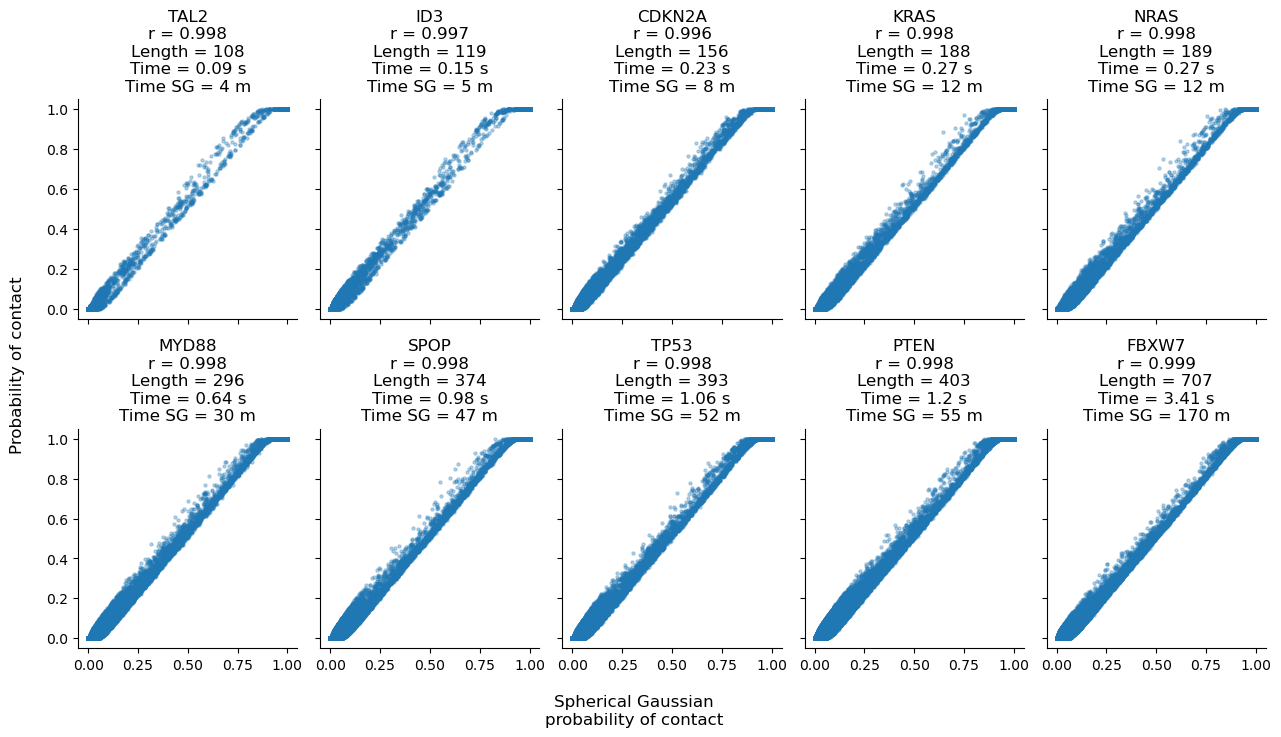

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(13, 7.4), sharex=True, sharey=True)
axes = axes.flatten()

for ax, gene in zip(axes, seq_df_genes.Gene.values):

    protein_len = len(seq_df[seq_df["Gene"] == gene].Seq.values[0])
    corr, min_default, min_alt = df[df["Gene"] == gene][["Corr", "Minutes_default", "Minutes_alt"]].values[0]
    arr1 = pcmaps[gene]["pCMAP"].flatten()
    arr2 = pcmaps[gene]["Alt_pCMAP"].flatten()

    # arr1 = (arr1 > 0.5).astype(float)
    # arr2 = (arr2 > 0.5).astype(float)

    ax.scatter(arr2, arr1, alpha=0.3, s=5)
    ax.set_title(f"{gene}\nr = {corr:.3f}\nLength = {protein_len}\nTime = {np.round(min_default * 60, 2)} s\nTime SG = {int(np.round(min_alt))} m")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ax.set_xlabel("pCMAP")
    # ax.set_ylabel("Alt_pCMAP")
    fig.supxlabel("Spherical Gaussian\nprobability of contact")
    fig.supylabel("Probability of contact\n")

plt.tight_layout()
plt.show()


# Comparison Bigger PAE and Switched PAE index

In [33]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


cgc_df = pd.read_csv(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [35]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False, rank=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d = df_o3d[df_o3d["Mut_in_top_vol"] > 1].reset_index(drop=True)
            
            if rank:
                df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)

In [36]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

In [40]:
TEST = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/tests"

RUN = "run_2025-05-27_03-25-01/"
SUBDIR = "mane_control_260525/"
o3d_output_dir_control = f"{TEST}/{SUBDIR}/{RUN}"

RUN = "run_2025-05-27_03-14-03/"
SUBDIR = "mane_bigger_pae_260525/"
o3d_output_dir_bigpae = f"{TEST}/{SUBDIR}/{RUN}"

RUN = "run_2025-05-27_03-24-16/"
SUBDIR = "mane_pae_index_260525"
o3d_output_dir_paeindex = f"{TEST}/{SUBDIR}/{RUN}"

In [38]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Mut_in_vol", "Score", "Score_obs_sim", "Rank", "pval", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene", 'C_gene', 'C_pos']].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)

    return df.reset_index(drop=True)

In [41]:
df_results_control = get_all_o3d_gene_result(cohort_df, o3d_output_dir_control) 
res_results_control = get_all_o3d_res_result(cohort_df, o3d_output_dir_control)
df_results_bigpae = get_all_o3d_gene_result(cohort_df, o3d_output_dir_bigpae)
res_results_bigpae = get_all_o3d_res_result(cohort_df, o3d_output_dir_bigpae)
df_results_paeindex = get_all_o3d_gene_result(cohort_df, o3d_output_dir_paeindex) 
res_results_paeindex = get_all_o3d_res_result(cohort_df, o3d_output_dir_paeindex)

In [ ]:
print("Significant unique gene p-values:")
print("Rank-based", len(df_results_control[df_results_control["pval"] < 0.01].Gene.unique()))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["pval"] < 0.01].Gene.unique()))
print("Res-based", len(df_results_resbase[df_results_resbase["pval"] < 0.01].Gene.unique()))

print("\nSignificant gene-cohort p-values:")
print("Rank-based", len(df_results_control[df_results_control["pval"] < 0.01]))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["pval"] < 0.01]))
print("Res-based", len(df_results_resbase[df_results_resbase["pval"] < 0.01]))

print("\nSignificant unique gene q-values:")
print("Rank-based", len(df_results_control[df_results_control["qval"] < 0.01].Gene.unique()))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["qval"] < 0.01].Gene.unique()))
print("Res-based", len(df_results_resbase[df_results_resbase["qval"] < 0.01].Gene.unique()))

print("\nSignificant gene-cohort q-values:")
print("Rank-based", len(df_results_control[df_results_control["qval"] < 0.01]))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["qval"] < 0.01]))
print("Res-based", len(df_results_resbase[df_results_resbase["qval"] < 0.01]))

print("\nSignificant clusters-cohort p-values:")
print("Rank-based", len(res_results_control[res_results_control["pval"] < 0.01]))
print("Rank-based no-std", len(res_results_nostd[res_results_nostd["pval"] < 0.01]))
print("Res-based", len(res_results_resbase[res_results_resbase["pval"] < 0.01]))

In [48]:
genes_control = df_results_control[df_results_control["qval"] < 0.01].Gene.unique()
genes_bigpaea = df_results_bigpae[df_results_bigpae["qval"] < 0.01].Gene.unique()
genes_paeindex = df_results_paeindex[df_results_paeindex["qval"] < 0.01].Gene.unique()

print("O3D only:", [g for g in genes_control if g not in genes_bigpaea])
print("4/3 PAE only:", [g for g in genes_bigpaea if g not in genes_control])

print("O3D only:", [g for g in genes_control if g not in genes_paeindex])
print("Inverted PAE index only:", [g for g in genes_paeindex if g not in genes_control])

O3D only: ['PPP1R13L', 'ATG2A', 'FOXD4L1', 'COL21A1', 'BMP5']
4/3 PAE only: ['MAF', 'ZNF253', 'OR2A14']
O3D only: ['BMP5']
Inverted PAE index only: ['CARD11', 'MAF', 'ZNF253', 'ZNF728', 'RARS2']


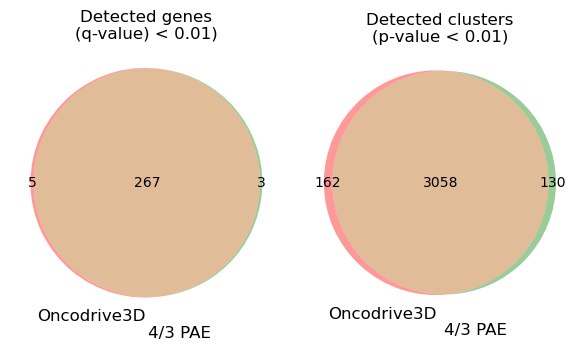

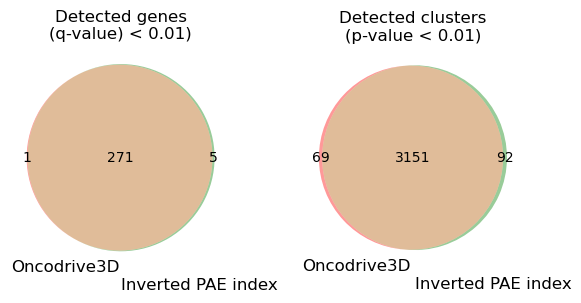

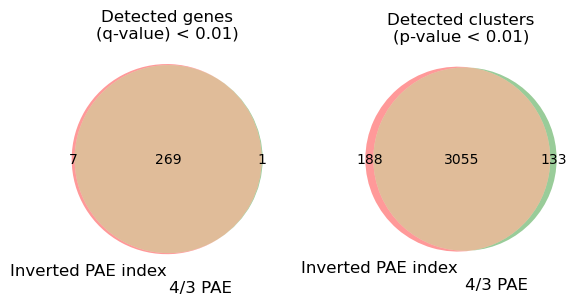

In [43]:
from matplotlib_venn import venn2

def plot_venn(df1, df2, df_res1, df_res2, title1="", title2="", label1="", label2=""):
    
    # Genes (qval)
    set1_genes_qval = set(df1[df1["qval"] < 0.01].Gene)
    set2_genes_qval = set(df2[df2["qval"] < 0.01].Gene)
    
    # Clusters (pval)
    set1_clusters = set(df_res1[df_res1["pval"] < 0.01][["Gene", "Pos"]]
                        .astype(str).agg(" | ".join, axis=1))
    set2_clusters = set(df_res2[df_res2["pval"] < 0.01][["Gene", "Pos"]]
                        .astype(str).agg(" | ".join, axis=1))
    

    fig, axes = plt.subplots(1, 2, figsize=(6, 5))

    # Venn diagrams
    venn2([set1_genes_qval, set2_genes_qval], set_labels=(label1, label2), ax=axes[0])
    axes[0].set_title("Detected genes\n(q-value) < 0.01)")

    venn2([set1_clusters, set2_clusters], set_labels=(label1, label2), ax=axes[1])
    axes[1].set_title("Detected clusters\n(p-value < 0.01)")

    plt.tight_layout()
    plt.show()
    
plot_venn(
    df_results_control, df_results_bigpae, 
    res_results_control, res_results_bigpae,
    label1="Oncodrive3D", label2="\n4/3 PAE")

plot_venn(
    df_results_control, df_results_paeindex, 
    res_results_control, res_results_paeindex,
    label1="Oncodrive3D", label2="\nInverted PAE index")

plot_venn(
    df_results_paeindex, df_results_bigpae, 
    res_results_paeindex, res_results_bigpae,
    label1="Inverted PAE index", label2="\n4/3 PAE")